### Make Figure 2
Results from tuning region size in semi-synthetic experiment

In [2]:
LOAD_CACHE = True
SAVE_RESULT = False

In [3]:
RESULT_DIR = # TODO directory to place results
FIG_DIR = 'figs/'

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

In [5]:
from sklearn import preprocessing 
from sklearn import model_selection as ms
from sklearn import pipeline
from sklearn import linear_model as lm
from IterativeRegionEstimator import IterativeRegionEstimator

In [6]:
import data_processing.semisynth_dataloader as ssdl
from run_baseline_models import run_model
import numpy as np
from tqdm.notebook import tqdm
import data_processing.semisynth_subsets as sub

import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm.notebook import tqdm

In [7]:
# Number of datasets to generate
N_ITER_DATAGEN = 30
# Within each dataset, how many permutations to test?
N_ITER_PER_BETA = 40
beta_seq = np.linspace(0.02, 0.42, 11) # increments of 0.04

LOGIT = 1.5
SUB = sub.misdemeanor_under35  # True beta is around 0.22
SUB_STR = 'young_misdemeanor'

EXP_STR = f'sub_{SUB_STR}_datasets_{N_ITER_DATAGEN}_iter_{N_ITER_PER_BETA}_logit_{LOGIT}'

In [8]:
if LOAD_CACHE: 
    with open(f'{RESULT_DIR}/semisynth-recoverbeta-{EXP_STR}-raw.pkl', 'rb') as f:
        results_list = pkl.load(f)
else:
    results_list = []
    scores_data = {}
    for seed_data in tqdm(range(N_ITER_DATAGEN)):
        dd = ssdl.load_semi_synthetic_compas_data(
            seed=seed_data, logit_adjust=LOGIT, num_agents=None,
            subset_func=SUB,
            verbose=False, cache=False)
        
        if seed_data == 0:
            true_beta = dd['true_beta']
            print(f'Beta: {true_beta}')

        train_valid_idxs = np.concatenate([dd['train_idxs'], dd['valid_idxs']])

        # Note that we are treating the entire training/validation set as "training" for this
        X_train = dd['X'][train_valid_idxs]
        A_train = dd['d'][train_valid_idxs]
        y_train = dd['t'][train_valid_idxs]

        # Ridge Regression for the region and Logistic Regression for the outcome model
        lr_outcome = pipeline.Pipeline(
                    [('scaler', preprocessing.StandardScaler()),
                     ('logReg', lm.LogisticRegression(
                         fit_intercept=True, solver='lbfgs', 
                         random_state=0, max_iter=1000))])

        lr_region = pipeline.Pipeline(
                    [('scaler', preprocessing.StandardScaler()),
                     ('Ridge', lm.Ridge(
                         fit_intercept=True, 
                         random_state=0, max_iter=1000))])

        outcome_params = {
            'logReg__C': [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
        }

        region_params = {
            'Ridge__alpha': [0.01, 0.1, 1, 10, 100]
        }

        outcome_model = ms.GridSearchCV(lr_outcome, scoring='roc_auc', param_grid=outcome_params)
        outcome_model = outcome_model.fit(X_train, y_train)

        # Note that we do not fit the region model, b/c this is done as part of the iter model routine
        region_model = ms.GridSearchCV(lr_region, scoring='neg_mean_squared_error', param_grid=region_params)

        for this_beta in tqdm(beta_seq):
            # Fit the original model, get the score
            this_beta_iter_model = IterativeRegionEstimator(
                    region_modelclass=deepcopy(region_model),
                    beta=this_beta)

            this_beta_iter_model = this_beta_iter_model.fit(X_train, y_train, A_train, outcome_model)
            fitted_score = this_beta_iter_model.score(X_train, y_train, A_train)

            # Randomly permute the agents, get a new training score
            these_scores = []
            for seed_shuffle in range(N_ITER_PER_BETA):    
                # Randomly shuffle the agents
                rng = np.random.default_rng(seed=seed_shuffle)
                this_A_random = rng.permutation(A_train)

                this_region_model = deepcopy(region_model)

                # Fit the iterative estimator, using the shuffled agents
                this_iter_model = IterativeRegionEstimator(
                    region_modelclass=this_region_model,
                    beta=this_beta)
                this_iter_model = this_iter_model.fit(X_train, y_train, this_A_random, outcome_model)

                this_score = this_iter_model.score(X_train, y_train, this_A_random)
                these_scores.append(this_score)    

            these_scores = np.array(these_scores)

            results_list.append({
                'data_seed': seed_data,
                'beta': this_beta,
                'fitted_train_score': this_beta_iter_model.score(X_train, y_train, A_train),
                'shuffle_train_mean': these_scores.mean(),
                'shuffle_train_upper_90_interval': np.quantile(these_scores, 0.95),
                'shuffle_train_lower_90_interval': np.quantile(these_scores, 0.05),
                'shuffle_train_std': these_scores.std(), 
                'raw_scores': these_scores}
            )

    if SAVE_RESULT: 
        with open(f'{RESULT_DIR}/semisynth-recoverbeta-{EXP_STR}-raw.pkl', 'wb') as f:
            pkl.dump(results_list, f)

# Visualize results

In [9]:
def get_percentile_score(d):
    return (100 - stats.percentileofscore(d['raw_scores'], d['fitted_train_score'])) * 0.01

def del_raw_add_perct(d):
    r = dict(d)
    r['percentile'] = get_percentile_score(d)
    del r['raw_scores']
    return r

plot_df = pd.DataFrame([del_raw_add_perct(r) for r in results_list])
plot_df['diff'] = plot_df['fitted_train_score'] - plot_df['shuffle_train_mean']
plot_df['zscore'] = plot_df['diff'] / plot_df['shuffle_train_std']
pd.set_option('display.float_format', '{:.3f}'.format)

In [10]:
true_beta = plot_df['true_beta'].values[0]

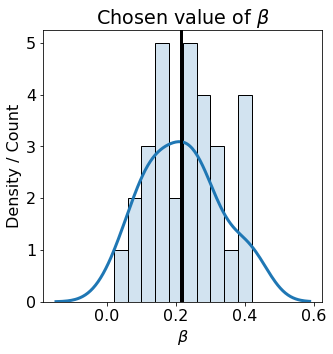

In [14]:
# Values of beta that minimize the p-value
min_pvalue = plot_df.iloc[plot_df.groupby('data_seed').idxmin()['percentile'].values]
plt.rcParams.update({'font.size':16})
fig, ax = plt.subplots(1, figsize=(5, 5))
sns.kdeplot(x='beta', data = min_pvalue, ax = ax, linewidth=3)
sns.histplot(x='beta', data = min_pvalue, bins=10, ax = ax, alpha=0.2)
ax.axvline(x = true_beta, color='black', linewidth=3)
ax.set_xlabel("$\\beta$")
ax.set_ylabel("Density / Count")
ax.set_title("Chosen value of $\\beta$")
plt.savefig(f"{FIG_DIR}/semisynth-recoverbeta-{EXP_STR}-betachoices.pdf")

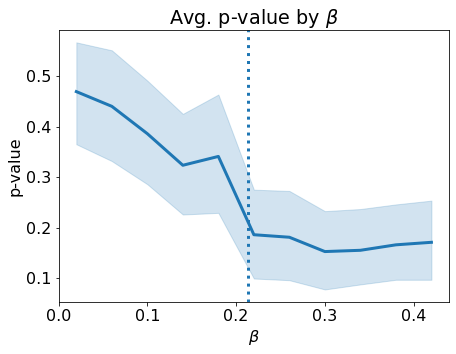

In [12]:
fig, ax = plt.subplots(1, figsize=(7, 5))
sns.lineplot(x = 'beta', y = 'percentile', data=plot_df, ax=ax, linewidth=3)
ax.set_title("Avg. p-value by $\\beta$")
ax.axvline(x = true_beta, linestyle='dotted', linewidth=3)
ax.set_xlabel("$\\beta$")
ax.set_ylabel("p-value")
plt.savefig(f"{FIG_DIR}/semisynth-recoverbeta-{EXP_STR}-pct-dist.pdf")